In [1]:
import sys
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
# Import supplementary visualizations code visuals.py
import visuals as vs
from sklearn.model_selection import train_test_split
# Pretty display for notebooks
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

In [2]:
# Initially, loading the city health behaviors and outcomes dataset
# from initial csv files. 
# csv files come with columns including year, city, measure, value etc
# so a column describes all measures, the column next describes corresponding 
# values. the code here reads in this data, then reformats
# to generate dicts with cities as keys to nested
# dicts where health metric is prevalence is the value 

'''
try:
    outcomes = pd.read_csv("500_Cities_Health_Outcomes_raw.csv", index_col = 'Unnamed: 0')
    behaviors = pd.read_csv("500_Cities_Health_Behaviors_raw.csv", index_col = 'Unnamed: 0')
    #data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Health Outcomes dataset has {} samples with {} features each.".format(*outcomes.shape)
    print "Unhealthy Behaviors dataset has {} samples with {} features each.".format(*behaviors.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"
'''    
    

'\ntry:\n    outcomes = pd.read_csv("500_Cities_Health_Outcomes_raw.csv", index_col = \'Unnamed: 0\')\n    behaviors = pd.read_csv("500_Cities_Health_Behaviors_raw.csv", index_col = \'Unnamed: 0\')\n    #data.drop([\'Region\', \'Channel\'], axis = 1, inplace = True)\n    print "Health Outcomes dataset has {} samples with {} features each.".format(*outcomes.shape)\n    print "Unhealthy Behaviors dataset has {} samples with {} features each.".format(*behaviors.shape)\nexcept:\n    print "Dataset could not be loaded. Is the dataset missing?"\n'

In [3]:
outcomes.iloc[500]

NameError: name 'outcomes' is not defined

In [ ]:

# Initially, loading the city health behaviors and outcomes dataset
# from initial csv files. 
# csv files come with columns including year, city, measure, value etc
# so a column describes all measures, the column next describes corresponding 
# values. the code here reads in this data, then reformats
# to generate dicts with cities as keys to nested
# dicts where health metric is prevalence is the value 

'''

outcomes_dict = {outcome.CityName:{outcome.Short_Question_Text: 0}}
behaviors_dict = {behavior.CityName:{behavior.Short_Question_Text: 0}}

for item in outcomes.itertuples():
    # if CityName is in current outcomes dict, just add metric and value. 
    # if not, add Cityname metric and value
    if item.CityName in outcomes_dict:
        outcomes_dict[item.CityName][item.Short_Question_Text] = item.Data_Value
    else:
        outcomes_dict[item.CityName] = {item.Short_Question_Text:item.Data_Value}
    
    # reformat latitude and longitude data
    geo_lat, geo_long = tuple(item.GeoLocation.strip('()').split(','))
    #print "lat = {} long = {}".format(geo_lat, geo_long)
    outcomes_dict[item.CityName]['GeoLat'] = float(geo_lat)
    outcomes_dict[item.CityName]['GeoLong'] = float(geo_long)
    
for item in behaviors.itertuples():
    # if CityName is in current outcomes dict, just add metric and value. 
    # if not, add Cityname metric and value
    if item.CityName in behaviors_dict:
        behaviors_dict[item.CityName][item.Short_Question_Text] = item.Data_Value
    else:
        behaviors_dict[item.CityName] = {item.Short_Question_Text:item.Data_Value}
    
    # reformat latitude and longitude data
    geo_lat, geo_long = tuple(item.GeoLocation.strip('()').split(','))
    #print "lat = {} long = {}".format(geo_lat, geo_long)
    behaviors_dict[item.CityName]['GeoLat'] = float(geo_lat)
    behaviors_dict[item.CityName]['GeoLong'] = float(geo_long)
    
    
    #behaviors_dict[item.CityName]['GeoLocation'] = item.GeoLocation
    
print item

# create dataframes from dicts
outcomes_df = pd.DataFrame.from_dict(outcomes_dict, 'index')
behaviors_df = pd.DataFrame.from_dict(behaviors_dict, 'index')


# to make future loading and unloading easier, the dataframes are
# written to csv files. we can now just read these files in already 
#formatted

outcomes_df.to_csv('500_Cities_Health_Outcomes.csv')
behaviors_df.to_csv('500_Cities_Health_Behaviors.csv')

'''

In [4]:
# reading in reformatted csv files directly into dataframes
try:
    outcomes_df = pd.read_csv('500_Cities_Health_Outcomes.csv')
    behaviors_df = pd.read_csv('500_Cities_Health_Behaviors.csv')
    print "Health Outcomes dataset has {} samples with {} features each.".format(*outcomes_df.shape)
    print "Unhealthy Behaviors dataset has {} samples with {} features each.".format(*behaviors_df.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"
    

#outcomes_df = outcomes_df.drop('GeoLong', 1, inplace = True)
#outcomes_df = outcomes_df.drop('GeoLat', 1, inplace = True)

Health Outcomes dataset has 474 samples with 16 features each.
Unhealthy Behaviors dataset has 474 samples with 8 features each.


In [5]:
# rename index to 'Cities' in behavior and outcomes dataframes (df)
behaviors_df.rename(columns = {'Unnamed: 0': 'Cities'}, inplace = True)
behaviors_df.set_index(['Cities'], inplace = True)
behaviors_df.head()

outcomes_df.rename(columns = {'Unnamed: 0': 'Cities'}, inplace = True)
outcomes_df.set_index(['Cities'], inplace = True)
#outcomes_df.index.names = ['Cities']
outcomes_df.head()

# combine outcomes and behaviors into one df so we can do correlations
# across all variables
frames = [outcomes_df, behaviors_df]
datacorr_df = pd.concat(frames, axis=1)

In [6]:
datacorr_df.head()

,Chronic Kidney Disease,GeoLat,COPD,Cancer (except skin),Arthritis,Mental Health,GeoLong,Teeth Loss,Stroke,High Cholesterol,...,Physical Health,High Blood Pressure,Coronary Heart Disease,GeoLat,Current Smoking,Physical Activity,GeoLong,Binge Drinking,Sleep,Obesity
Cities,,,,,,,,,,,,,,,,,,,,,
Abilene,3.3,32.454651,6.7,6.0,22.4,11.6,-99.738304,14.3,3.1,34.4,...,12.6,31.6,6.3,32.454651,19.6,27.7,-99.738304,16.2,35.4,33.7
Akron,3.3,41.080144,9.4,5.7,29.0,15.3,-81.521921,23.6,3.9,33.0,...,15.5,36.2,7.5,41.080144,26.8,31.0,-81.521921,14.8,44.1,37.3
Alameda,2.2,37.765085,4.3,5.7,18.5,9.8,-122.266490,7.5,2.2,31.3,...,9.6,24.3,4.5,37.765085,11.9,18.7,-122.266490,15.0,32.3,18.7
Albany,2.2,42.666397,7.1,5.8,25.7,13.2,-73.798683,16.5,3.3,33.8,...,13.1,33.4,6.0,42.666397,19.0,26.1,-73.798683,15.5,39.7,31.1
Albuquerque,2.9,35.105503,5.4,6.1,22.4,11.6,-106.647448,14.0,2.6,29.2,...,12.1,25.9,5.3,35.105503,18.8,20.4,-106.647448,14.5,32.8,25.5


/Users/robertbeetel/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


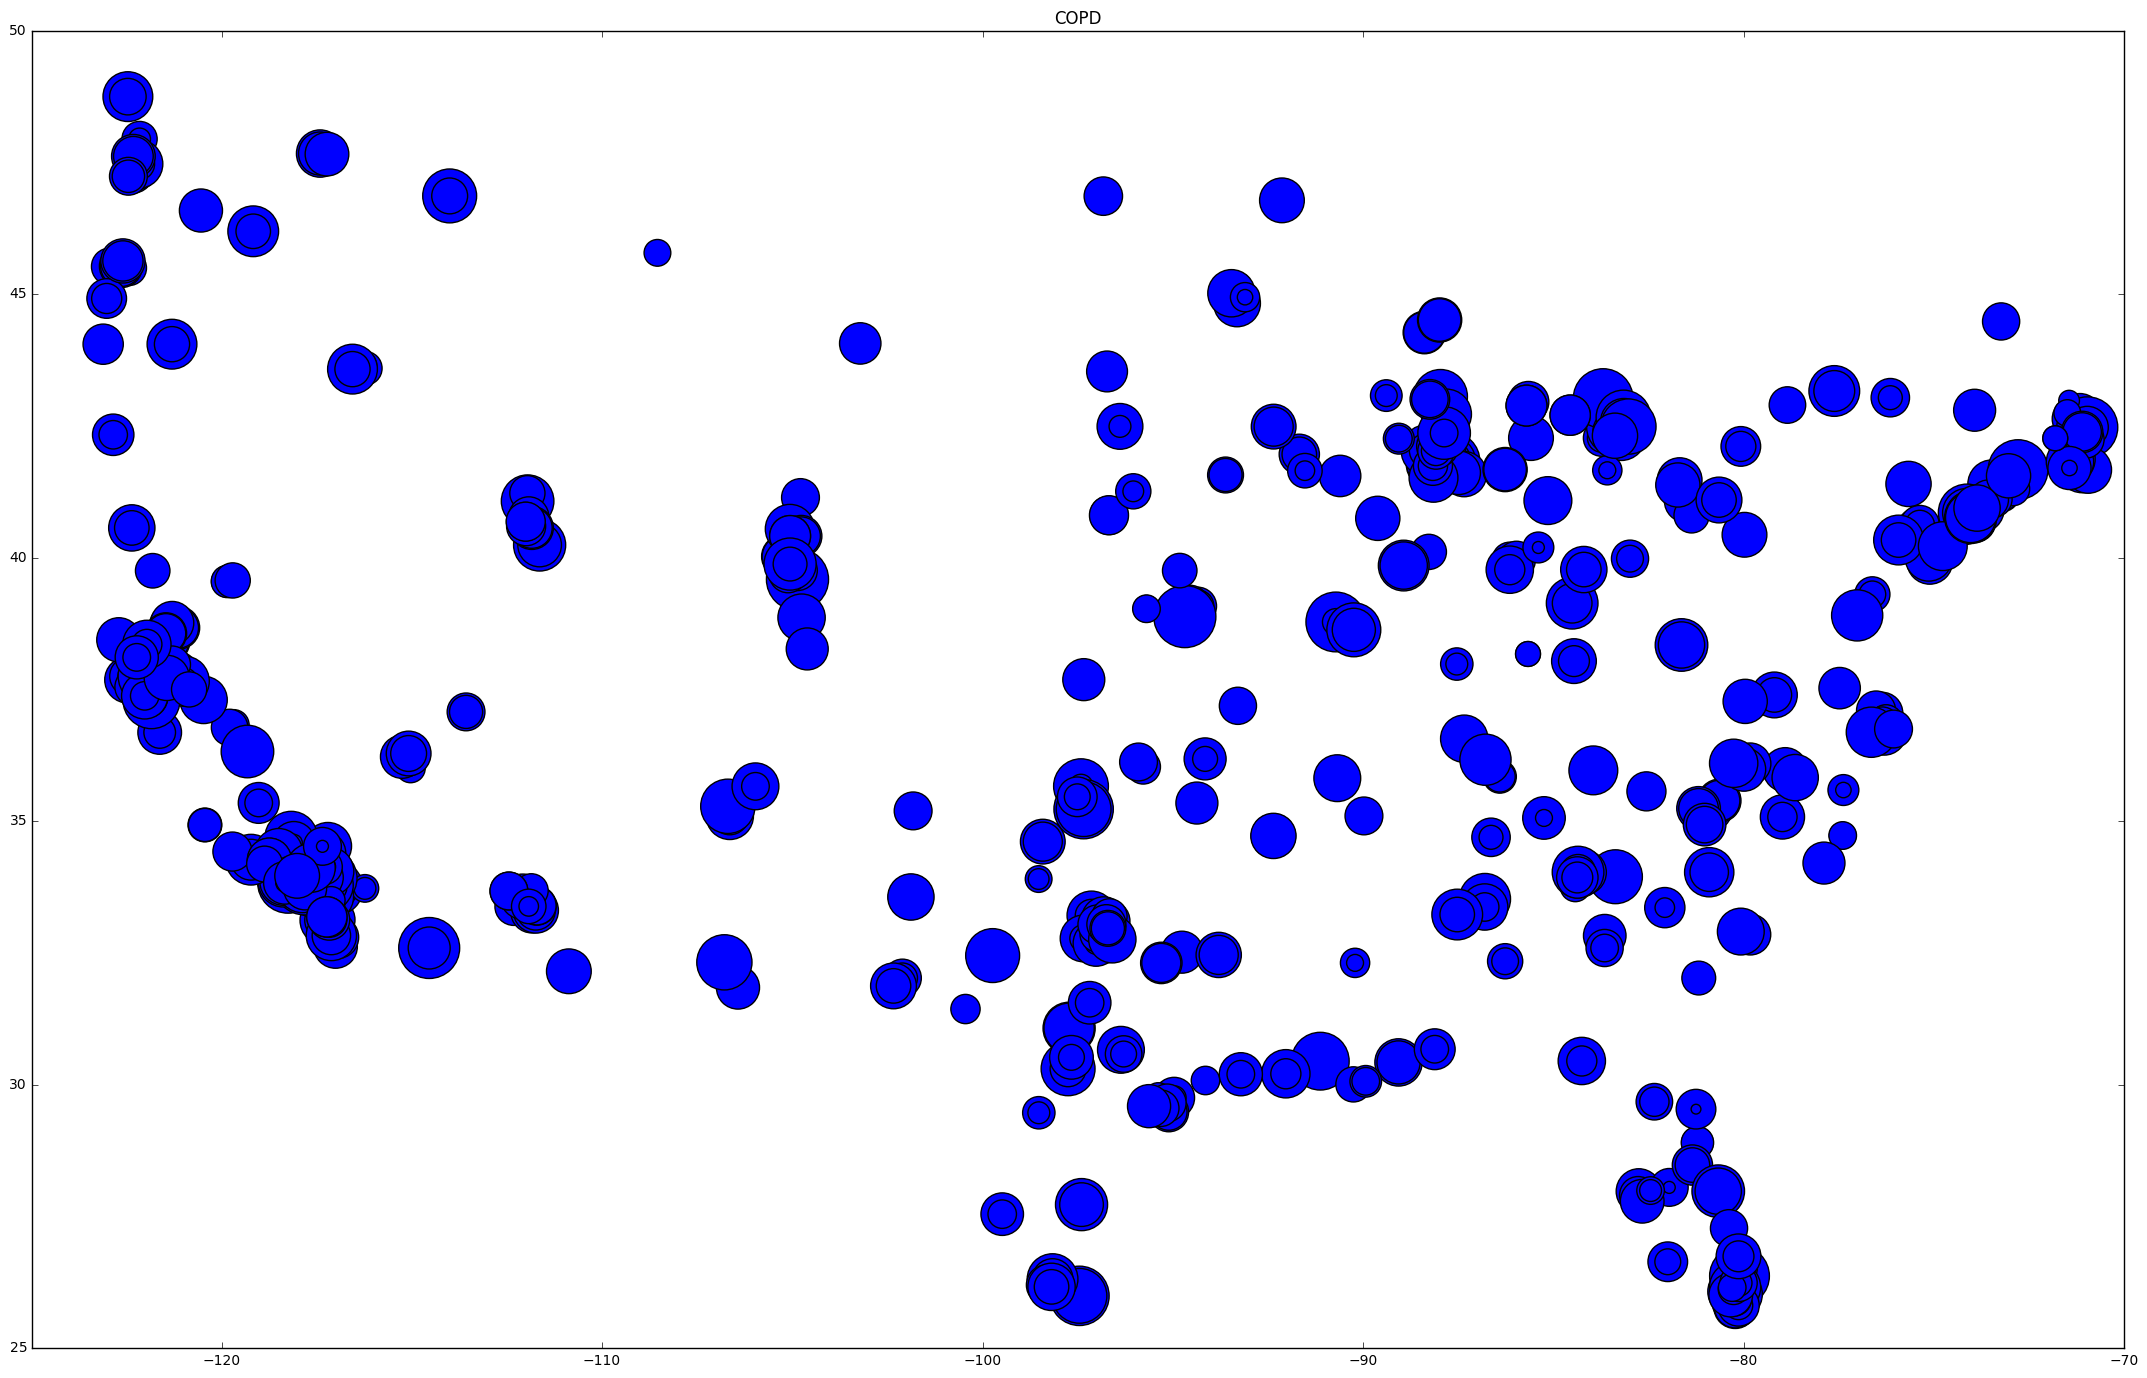

In [7]:
# code for displaying a cities condition prevalence, in this case COPD
# in its geographical location i.e. on a map, with the marker size 
# proportional to the prevalence value

# prevalence values are normalized 
#display(high_corr)
maxCOPD = datacorr_df.COPD.max()
minCOPD = datacorr_df.COPD.min()
rangeCOPD = maxCOPD - minCOPD

#plot data 
f, ax = plt.subplots(figsize=(55/2,35/2))
ax.set_title('COPD')
#plt.title("COPD in Continental US")
ax.axis([-125.0, -70.0, 25.0, 50.0])

COPD_prev = (datacorr_df['COPD'] - minCOPD)/rangeCOPD

# error message says element-wise comparison fails but plot still works

ax.scatter(datacorr_df.GeoLong, datacorr_df.GeoLat, s = 2000*COPD_prev)
#plt.figure(figsize =(20,10))
#plt.scatter(datacorr_df.GeoLong, datacorr_df.GeoLat, s = 30*(datacorr_df.COPD-minCOPD)/rangeCOPD)
plt.show()

In [8]:
# perform corrlation between all outcomes and behaviors
# select correlation values above certain thresholds and create
# list of correlated variables

corr_threshold = 0.80
high_corr = datacorr_df.corr()
high_corr = high_corr[high_corr >= corr_threshold]

col_names = high_corr.columns
#display(high_corr.iloc[0].name)
#display(high_corr.iloc[0][0])
#display(col_names[0])


In [9]:
datacorr_df.corr().Stroke

Chronic Kidney Disease    0.685028
GeoLat                   -0.059188
COPD                      0.831702
Cancer (except skin)     -0.221284
Arthritis                 0.725383
Mental Health             0.835944
GeoLong                   0.364517
Teeth Loss                0.885558
Stroke                    1.000000
High Cholesterol          0.530339
Current Asthma            0.677891
Diabetes                  0.877367
Physical Health           0.843972
High Blood Pressure       0.874823
Coronary Heart Disease    0.876573
GeoLat                   -0.059188
Current Smoking           0.780398
Physical Activity         0.813787
GeoLong                   0.364517
Binge Drinking           -0.489722
Sleep                     0.776520
Obesity                   0.852384
Name: Stroke, dtype: float64

In [10]:
# print items to confirm what we've got
for item in high_corr.head().itertuples():
    for i in range(len(item)):
        if not pd.isnull(item[i]):
            print "{}   {}".format(col_names[i], item[i])



Chronic Kidney Disease   Chronic Kidney Disease
GeoLat   1.0
Chronic Kidney Disease   GeoLat
COPD   1.0
Current Smoking   1.0
Chronic Kidney Disease   COPD
Cancer (except skin)   1.0
Mental Health   0.878478155698
GeoLong   0.891465214175
Stroke   0.874828554074
High Cholesterol   0.831702134952
Diabetes   0.811757019244
GeoLat   0.920078015072
Physical Activity   0.912706265807
Chronic Kidney Disease   Cancer (except skin)
Arthritis   1.0
Chronic Kidney Disease   Arthritis
Cancer (except skin)   0.878478155698
Mental Health   1.0
Stroke   0.804149346446
Diabetes   0.832442548251
Physical Activity   0.867117660798


In [11]:
not pd.isnull(item[i])

False

In [12]:
high_corr.Stroke

Chronic Kidney Disease         NaN
GeoLat                         NaN
COPD                      0.831702
Cancer (except skin)           NaN
Arthritis                      NaN
Mental Health             0.835944
GeoLong                        NaN
Teeth Loss                0.885558
Stroke                    1.000000
High Cholesterol               NaN
Current Asthma                 NaN
Diabetes                  0.877367
Physical Health           0.843972
High Blood Pressure       0.874823
Coronary Heart Disease    0.876573
GeoLat                         NaN
Current Smoking                NaN
Physical Activity         0.813787
GeoLong                        NaN
Binge Drinking                 NaN
Sleep                          NaN
Obesity                   0.852384
Name: Stroke, dtype: float64

In [13]:
# looking at variables correlated with Stroke
#figure out how to generate a list of the names of things highly correlated 
#with stroke
corr_threshold = 0.7
stroke_preds = []
for i in range(len(high_corr['Stroke'])):
    val = high_corr['Stroke'][i]
    if val > corr_threshold:
        print "{}   {}".format(high_corr.axes[0][i], val)
        stroke_preds.append(high_corr.axes[0][i])

# stroke is correlated with itself so we remove it as a variable
stroke_preds.remove('Stroke')

print stroke_preds



COPD   0.831702134952
Mental Health   0.835944251227
Teeth Loss   0.885558062872
Stroke   1.0
Diabetes   0.877367244945
Physical Health   0.843972193685
High Blood Pressure   0.874823345389
Coronary Heart Disease   0.876572867993
Physical Activity   0.813787042293
Obesity   0.852384375754
['COPD', 'Mental Health', 'Teeth Loss', 'Diabetes', 'Physical Health', 'High Blood Pressure', 'Coronary Heart Disease', 'Physical Activity', 'Obesity']


,COPD,Mental Health,Teeth Loss,Diabetes,Physical Health,High Blood Pressure,Coronary Heart Disease,Physical Activity,Obesity
Cities,,,,,,,,,
Abilene,6.7,11.6,14.3,10.9,12.6,31.6,6.3,27.7,33.7
Akron,9.4,15.3,23.6,13.0,15.5,36.2,7.5,31.0,37.3
Alameda,4.3,9.8,7.5,8.1,9.6,24.3,4.5,18.7,18.7
Albany,7.1,13.2,16.5,10.9,13.1,33.4,6.0,26.1,31.1
Albuquerque,5.4,11.6,14.0,9.3,12.1,25.9,5.3,20.4,25.5


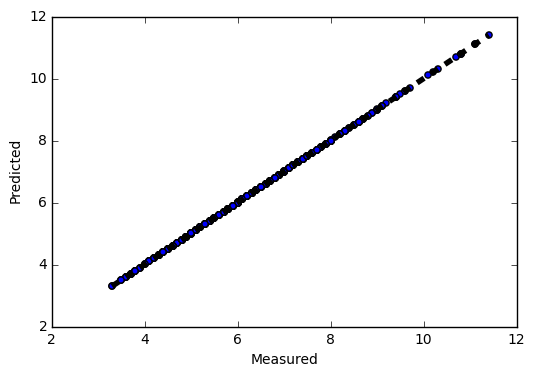

In [14]:
# behaviors_only_df = behaviors_df.drop(['GeoLong'], axis = 1)
# behaviors_only_df.head()

lr = LinearRegression()
X = datacorr_df[stroke_preds]
display(X.head())
y = datacorr_df.COPD
predicted = cross_val_predict(lr, X, y, cv = 10 )

fig, ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

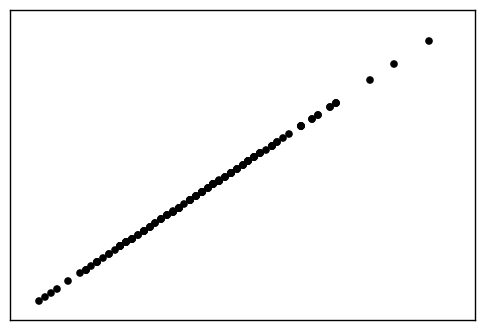

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,
                                                   random_state = 42)

lr.fit(X_train, y_train)
lr.score(X_test, y_test)
predicted = lr.predict(X_test)


plt.scatter(y_test, predicted,  color='black')
#plt.scatter(X_test['Current Smoking'], lr.predict(X_test), color='blue',
#         linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

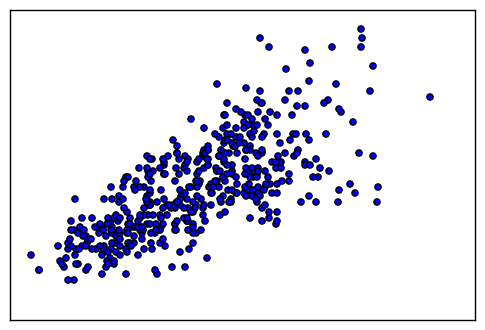

In [16]:
plt.scatter(X['Physical Activity'], y)
plt.xticks(())
plt.yticks(())
plt.show()



Cities
Abilene        3.1
Akron          3.9
Alameda        2.2
Albany         3.3
Albuquerque    2.6
Name: Stroke, dtype: float64

,COPD,Mental Health,Teeth Loss,Diabetes,Physical Health,High Blood Pressure,Coronary Heart Disease,Physical Activity,Obesity
Cities,,,,,,,,,
Abilene,6.7,11.6,14.3,10.9,12.6,31.6,6.3,27.7,33.7
Akron,9.4,15.3,23.6,13.0,15.5,36.2,7.5,31.0,37.3
Alameda,4.3,9.8,7.5,8.1,9.6,24.3,4.5,18.7,18.7
Albany,7.1,13.2,16.5,10.9,13.1,33.4,6.0,26.1,31.1
Albuquerque,5.4,11.6,14.0,9.3,12.1,25.9,5.3,20.4,25.5


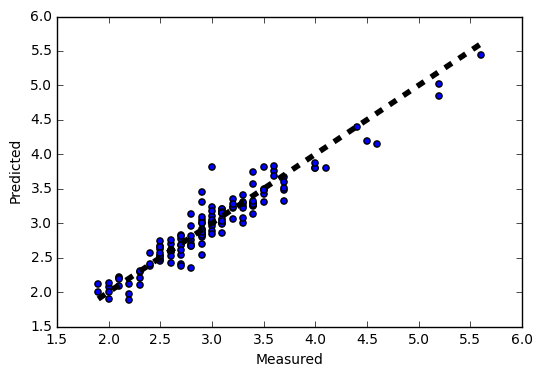

In [17]:
stroke_y = datacorr_df['Stroke']
display(stroke_y.head())
stroke_X = datacorr_df[stroke_preds]
display(stroke_X.head())
X_train, X_test, y_train, y_test = train_test_split(stroke_X, stroke_y, test_size = 0.3,
                                                   random_state = 42)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

predicted = lr.predict(X_test)


fig, ax = plt.subplots()
ax.scatter(y_test, predicted)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

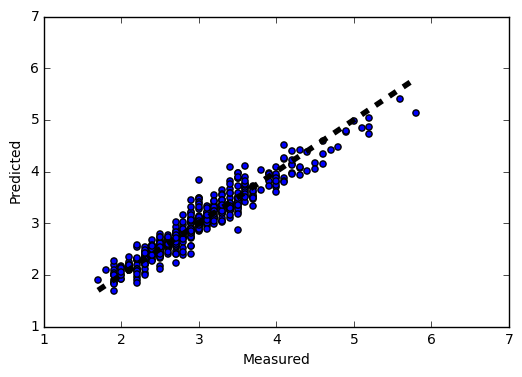

In [18]:
predicted = cross_val_predict(lr, stroke_X, stroke_y, cv = 10)
predicted = cross_val_predict(lr, stroke_X, stroke_y, cv = 10)
fig, ax = plt.subplots()
ax.scatter(stroke_y, predicted)
ax.plot([stroke_y.min(), stroke_y.max()], [stroke_y.min(), stroke_y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [19]:
print np.mean((predicted - stroke_y)**2)

0.0347624935757


In [20]:
from sklearn import svm
print "wonk"

wonk


In [21]:
clf = svm.SVR(kernel = "linear", C = 1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.92007489382486685

In [22]:
scores = cross_val_score(clf, X_test, y_test, cv = 10 )

In [23]:
scores.mean()

0.86084008624063768

In [24]:
scores.std()**

SyntaxError: invalid syntax (<ipython-input-24-5a1f6947068f>, line 1)

In [25]:
from sklearn import metrics
predicted = cross_val_predict(lr, X_test, y_test, cv = 10)
metrics.r2_score(y_test, predicted)

0.9020478754178658

In [26]:
print "wonk"

wonk


In [28]:
clf2 = svm.SVR(kernel = "poly", C = 1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.92007489382486685